## Пайплайн обработки каждого датасета

### 1. Анализ метаданных в словаре.

    Цель: Отобрать ключевые признаки еще до обработки, чтобы сократить объем данных.

    Смотрим на описание, ищем технические метаданные, дубли по смыслу  

##### Гипотиза - мы отсеим большую часть на этапах очистки от пропусков , дублей , констант . 

1. На данном этапе смотрим полверхностно на очевидные метаданные
2. Вернемся к анализу метаданных в словарях, когда сократим и обработаем признаки на поздних этапах обработки

In [68]:
# библиотеки Python 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import Pool, CatBoostRegressor

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection


In [69]:
# загружаем данные с признаками

train_card_spending = pd.read_parquet('data/train_card_spending.parquet')

card_spending_dict = pd.read_csv('data/dictionary_card_spending.csv')


In [70]:
# Общая информация об основных признаках

def display_main_info(df, df_dict):

    display(df.head(n = 5))
    display(df.tail())
    display(df.info())
    display(df.dtypes.value_counts())
    
    categorical_features_list = cat_features(df)
    
    display(categorical_features_list)
    
    display_info_about_cat(categorical_features_list, df_dict)
    
    # отдельно смотрим на категории описаний, вдруг чего ненужное углядим
    
    display(df_dict['category'].value_counts())
    display(df_dict['feature_group'].value_counts())
    display(df_dict['modeling_type'].value_counts())

# функция возвращает список категориальных признаков
def cat_features(df):
    features = df.columns

    categorical_features = df[features].select_dtypes(include=['object']).columns

    
    for feature in categorical_features:
        df[feature] = df[feature].astype(str)

    #categorical_features_indices = np.where(df.dtypes == 'object')[0]

    return (categorical_features)

def display_info_about_cat(cf_list, df_dict):
    with pd.option_context('display.max_colwidth', 150):
        display(df_dict[df_dict['feature'].isin(cf_list)])

In [71]:
# зпускаем наши функцию просмотра инфы об датасете

display_main_info(train_card_spending, card_spending_dict)


,user_id,cat_maxspend_v1_1,cat_maxspend_v1_12,cat_maxspend_v1_3,cat_maxspend_v1_6,cat_maxspend_v2_1,cat_maxspend_v2_12,cat_maxspend_v2_3,cat_maxspend_v2_6,cc_avg_trns_12m,...,sum_tr_travel_agencies_3,sum_tr_travel_agencies_6,sum_tr_trip_12m,sum_tr_trip_1m,sum_tr_trip_3m,sum_tr_trip_6m,sum_tr_unknown_1,sum_tr_unknown_12,sum_tr_unknown_3,sum_tr_unknown_6
0,9,None,None,None,None,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,None,None,None,None,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,LEISURE GOODS RETAIL,MEDICAL/HEALTH SERVICES,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL,MEDICAL/HEALTH SERVICES,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,None,None,None,None,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20259.037109,53401.761719,19749.404297,25131.3125
4,15,None,None,None,None,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,user_id,cat_maxspend_v1_1,cat_maxspend_v1_12,cat_maxspend_v1_3,cat_maxspend_v1_6,cat_maxspend_v2_1,cat_maxspend_v2_12,cat_maxspend_v2_3,cat_maxspend_v2_6,cc_avg_trns_12m,...,sum_tr_travel_agencies_3,sum_tr_travel_agencies_6,sum_tr_trip_12m,sum_tr_trip_1m,sum_tr_trip_3m,sum_tr_trip_6m,sum_tr_unknown_1,sum_tr_unknown_12,sum_tr_unknown_3,sum_tr_unknown_6
213340,999984,GENERAL DEPARTMENT STORE,TAX/GOVT SERVICES,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE,TAX/GOVT SERVICES,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE,2.449037,...,NaN,582.025757,604.131104,NaN,NaN,559.213806,9317.420898,0.000000,3899.128906,5819.515625
213341,999985,None,FASHION RETAIL,None,TELECOMMUNICATION,None,FASHION RETAIL,None,TELECOMMUNICATION,31169.755859,...,NaN,NaN,12388.294922,NaN,NaN,NaN,NaN,0.000000,NaN,2867.141113
213342,999987,RESTAURANTS_FASTFOOD,APPLIANCE RETAIL,APPLIANCE RETAIL,APPLIANCE RETAIL,RESTAURANTS_FASTFOOD,APPLIANCE RETAIL,APPLIANCE RETAIL,APPLIANCE RETAIL,-1.000000,...,108.045372,133.868698,672.577271,NaN,748.486084,701.849304,13027.108398,29194.824219,4972.825195,8952.305664
213343,999997,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,4.776433,...,NaN,NaN,7030.937988,4837.589355,7018.262695,7056.882324,NaN,0.000000,7043.712891,4457.611816
213344,999999,None,None,None,None,None,None,None,None,1.069545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213345 entries, 0 to 213344
Columns: 631 entries, user_id to sum_tr_unknown_6
dtypes: float64(622), int32(1), object(8)
memory usage: 1.0+ GB


None

float64    622
object       8
int32        1
Name: count, dtype: int64

Index(['cat_maxspend_v1_1', 'cat_maxspend_v1_12', 'cat_maxspend_v1_3',
       'cat_maxspend_v1_6', 'cat_maxspend_v2_1', 'cat_maxspend_v2_12',
       'cat_maxspend_v2_3', 'cat_maxspend_v2_6'],
      dtype='object')

,feature,modeling_type,description,category,feature_group
1,cat_maxspend_v1_1,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 1 мес,MCC категория (максимальные траты),Карты/Категории трат
2,cat_maxspend_v1_12,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 12 мес,MCC категория (максимальные траты),Карты/Категории трат
3,cat_maxspend_v1_3,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 3 мес,MCC категория (максимальные траты),Карты/Категории трат
4,cat_maxspend_v1_6,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 6 мес,MCC категория (максимальные траты),Карты/Категории трат
5,cat_maxspend_v2_1,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail) за последние 1 мес,MCC категория (максимальные траты),Карты/Категории трат
6,cat_maxspend_v2_12,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail) за последние 12 мес,MCC категория (максимальные траты),Карты/Категории трат
7,cat_maxspend_v2_3,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail)за последние 3 мес,MCC категория (максимальные траты),Карты/Категории трат
8,cat_maxspend_v2_6,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail)за последние 6 мес,MCC категория (максимальные траты),Карты/Категории трат


category
Транзакции                                178
Категория MCC insurance                     8
Категория MCC restaurants_delivery          8
Категория MCC leisuregoods retail           8
Категория MCC lodging                       8
Категория MCC medical/health services       8
Категория MCC membership clubs              8
Категория MCC music/digital/videostore      8
Категория MCC office_supplies               8
Категория MCC penalty                       8
Категория MCC pet_ retail/service           8
Категория MCC pharmacy/drugstores           8
Категория MCC postal/courier services       8
Категория MCC restaurants                   8
Категория MCC restaurants_alcohol           8
Категория MCC restaurants_fastfood          8
Категория MCC pos                           8
Категория MCC spa/beauty services           8
Категория MCC sporting goods retail         8
Категория MCC sports&recreation             8
Категория MCC supermarkets                  8
Категория MCC tax/govt se

feature_group
Карты/Категории трат    630
Name: count, dtype: int64

modeling_type
numerical      622
categorical      8
ключ             1
Name: count, dtype: int64

In [72]:
# посмотрим на категории 
with pd.option_context('display.max_colwidth', 150):
    display(card_spending_dict[card_spending_dict['modeling_type'] == 'categorical'])

,feature,modeling_type,description,category,feature_group
1,cat_maxspend_v1_1,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 1 мес,MCC категория (максимальные траты),Карты/Категории трат
2,cat_maxspend_v1_12,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 12 мес,MCC категория (максимальные траты),Карты/Категории трат
3,cat_maxspend_v1_3,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 3 мес,MCC категория (максимальные траты),Карты/Категории трат
4,cat_maxspend_v1_6,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 6 мес,MCC категория (максимальные траты),Карты/Категории трат
5,cat_maxspend_v2_1,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail) за последние 1 мес,MCC категория (максимальные траты),Карты/Категории трат
6,cat_maxspend_v2_12,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail) за последние 12 мес,MCC категория (максимальные траты),Карты/Категории трат
7,cat_maxspend_v2_3,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail)за последние 3 мес,MCC категория (максимальные траты),Карты/Категории трат
8,cat_maxspend_v2_6,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail)за последние 6 мес,MCC категория (максимальные траты),Карты/Категории трат


In [73]:
# рассмотрим категории , которые в основном Df не имеют таких признаков , т е определяются как int64

categorical_features_list = cat_features(train_card_spending)

cat_indict = card_spending_dict[card_spending_dict['modeling_type'] == 'categorical']['feature'].tolist()

cat_indict = [x for x in cat_indict if x not in categorical_features_list]

display(train_card_spending[cat_indict].head( n = 10))

for column in cat_indict:
    display(train_card_spending[column].value_counts())



""
0
1
2
3
4
5
6
7
8
9


**Первичный анализ мета-данных показал что, категориальных признаков  в мета данный = кат признакам в данных**

### 2. Анализ данных и первичная очистка

- **Пропуски**:
- **Важно**: CatBoost сам обрабатывает пропуски, но лучше явно контролировать процесс.  
  - Числовые признаки: на данном этапе удалим признаки с порогом пропусков более 80% и заполним пропуск явно (-999) . **Возможно вернуться к этому этапу после первого круга отсева признаков**
  - Категориальные: создаем отдельную категорию `"MISSING"` ,явно указываем CatBoost на категориальные признаки
  - Категориальные: редкие категории (например, <1% данных) объединить в `"OTHER"`. 
  

In [74]:
# функция удаляет признаки с пропусками более threshold % данных 
def drop_null(df, threshold):
    cols_null_percent = df.isnull().mean()*100
    cols_with_null = cols_null_percent[cols_null_percent > threshold].sort_values( ascending = False)
    display(cols_with_null)
    drop_list = cols_with_null.index.tolist()
    return drop_list




In [75]:
# удалим столбцы с пропусками с заданным порогом
drop_list = drop_null(train_card_spending, 70)

train = train_card_spending.drop(columns = drop_list)

sum_tr_house_rental_12            100.000000
sum_tr_house_rental_6             100.000000
sum_tr_house_rental_1             100.000000
sum_tr_house_rental_3             100.000000
sum_tr_financial_services_1        99.992969
                                     ...    
sum_tr_unknown_12                  71.571398
sum_tr_food_retail_alcohol_12      71.430312
sum_tr_restaurant_1m               71.066114
sum_tr_oil_12m                     70.891748
sum_tr_fuel_service_station_12     70.891748
Length: 242, dtype: float64

In [76]:
# заполним пропуски в категориальных признаках
# 1. создадим список всех кат признаков используя мета данные в словарях

def full_catlist(df, df_dict):
    categorical_features_df = list(cat_features(df))
    categorical_features_dfdict = df_dict[(df_dict['modeling_type'] == 'categorical') & (~df_dict['feature'].isin(drop_list)) ]['feature'].tolist()
    categorical_features_full = list(set(categorical_features_df + categorical_features_dfdict))
    return categorical_features_full

categorical_features_full = full_catlist(train_card_spending, card_spending_dict)

categorical_features_full

['cat_maxspend_v1_6',
 'cat_maxspend_v2_6',
 'cat_maxspend_v1_12',
 'cat_maxspend_v2_12',
 'cat_maxspend_v1_3',
 'cat_maxspend_v2_3',
 'cat_maxspend_v2_1',
 'cat_maxspend_v1_1']

In [77]:
# 2. Заполним пропуски в категориях , там есть и пустые и NaN 
def fill_cat_nan(df, cat_list):
    df[cat_list] = df[cat_list].fillna("MISSING")
    df[cat_list] = df[cat_list].replace('', 'MISSING')
    return df

train_card_spending = fill_cat_nan(train_card_spending, categorical_features_full)


In [78]:
# зафиксируем для контроля число пропусков
mask = train_card_spending[categorical_features_full] == 'MISSING'
total_miss = mask.values.sum()
total_miss

0

In [79]:
display(train_card_spending[categorical_features_full])

,cat_maxspend_v1_6,cat_maxspend_v2_6,cat_maxspend_v1_12,cat_maxspend_v2_12,cat_maxspend_v1_3,cat_maxspend_v2_3,cat_maxspend_v2_1,cat_maxspend_v1_1
0,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None
2,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL,MEDICAL/HEALTH SERVICES,MEDICAL/HEALTH SERVICES,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL,LEISURE GOODS RETAIL
3,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
213340,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE,TAX/GOVT SERVICES,TAX/GOVT SERVICES,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE,GENERAL DEPARTMENT STORE
213341,TELECOMMUNICATION,TELECOMMUNICATION,FASHION RETAIL,FASHION RETAIL,None,None,None,None
213342,APPLIANCE RETAIL,APPLIANCE RETAIL,APPLIANCE RETAIL,APPLIANCE RETAIL,APPLIANCE RETAIL,APPLIANCE RETAIL,RESTAURANTS_FASTFOOD,RESTAURANTS_FASTFOOD
213343,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL,FOOD_RETAIL_ALCOHOL


In [80]:
# посмотрим на категории , это важно потому что дальше мы удалим редкие , но без предварительного анализа это может навредить

for column in categorical_features_full:
    display(train_card_spending[column].value_counts())

cat_maxspend_v1_6
None                         101061
FASHION RETAIL                11394
TELECOMMUNICATION             10560
GENERAL DEPARTMENT STORE       9692
RESTAURANTS_FASTFOOD           9224
CONSTRUCTION SERVICES          8003
MEDICAL/HEALTH SERVICES        6688
FUEL/SERVICE STATION           5860
FOOD RETAIL                    5582
PHARMACY/DRUG STORES           4802
AUTO SERVICES                  3625
TRAVEL AGENCIES                3557
TRANSPORTATION_OTHER           3091
APPLIANCE RETAIL               3026
RESTAURANTS                    2644
DIRECT MARKETING               2614
FOOD_RETAIL_ALCOHOL            2054
AIRLINES                       1985
TAX/GOVT SERVICES              1781
TRANSPORTATION_RZD             1495
LODGING                        1276
EDUCATION                      1120
INSURANCE                      1070
BUSINESS SERVICES               952
TRANSPORTATION_TAXI             876
SPORTS & RECREATION             815
JEWELRY RETAIL                  790
MUSIC/DIGI

cat_maxspend_v2_6
None                         101734
FASHION RETAIL                11772
TELECOMMUNICATION             10817
GENERAL DEPARTMENT STORE      10162
RESTAURANTS_FASTFOOD           9940
CONSTRUCTION SERVICES          8304
MEDICAL/HEALTH SERVICES        6851
FUEL/SERVICE STATION           6291
PHARMACY/DRUG STORES           5485
AUTO SERVICES                  3742
TRAVEL AGENCIES                3590
TRANSPORTATION_OTHER           3355
APPLIANCE RETAIL               3098
RESTAURANTS                    2781
DIRECT MARKETING               2646
FOOD_RETAIL_ALCOHOL            2278
AIRLINES                       1998
TAX/GOVT SERVICES              1815
TRANSPORTATION_RZD             1537
LODGING                        1291
EDUCATION                      1135
INSURANCE                      1090
BUSINESS SERVICES               967
TRANSPORTATION_TAXI             886
SPORTS & RECREATION             832
JEWELRY RETAIL                  800
MUSIC/DIGITAL/VIDEO STORE       755
TOBACCO_RE

cat_maxspend_v1_12
None                         87553
FASHION RETAIL               14059
GENERAL DEPARTMENT STORE     11845
TELECOMMUNICATION            11374
RESTAURANTS_FASTFOOD         10743
CONSTRUCTION SERVICES        10206
MEDICAL/HEALTH SERVICES       7519
FUEL/SERVICE STATION          6649
FOOD RETAIL                   5209
PHARMACY/DRUG STORES          5198
TRAVEL AGENCIES               4373
AUTO SERVICES                 4008
APPLIANCE RETAIL              3713
TRANSPORTATION_OTHER          3180
DIRECT MARKETING              2333
TAX/GOVT SERVICES             2303
FOOD_RETAIL_ALCOHOL           2294
RESTAURANTS                   2282
AIRLINES                      2131
EDUCATION                     1374
LODGING                       1326
TRANSPORTATION_RZD            1321
INSURANCE                     1111
BUSINESS SERVICES             1016
TRANSPORTATION_TAXI            963
JEWELRY RETAIL                 836
SPORTS & RECREATION            816
ENTERTAINMENT                  669
P

cat_maxspend_v2_12
None                         88161
FASHION RETAIL               14428
GENERAL DEPARTMENT STORE     12305
TELECOMMUNICATION            11588
RESTAURANTS_FASTFOOD         11419
CONSTRUCTION SERVICES        10479
MEDICAL/HEALTH SERVICES       7682
FUEL/SERVICE STATION          7015
PHARMACY/DRUG STORES          5907
TRAVEL AGENCIES               4406
AUTO SERVICES                 4099
APPLIANCE RETAIL              3788
TRANSPORTATION_OTHER          3420
FOOD_RETAIL_ALCOHOL           2500
RESTAURANTS                   2381
DIRECT MARKETING              2360
TAX/GOVT SERVICES             2347
AIRLINES                      2144
EDUCATION                     1387
TRANSPORTATION_RZD            1372
LODGING                       1339
INSURANCE                     1125
BUSINESS SERVICES             1032
TRANSPORTATION_TAXI            972
JEWELRY RETAIL                 848
SPORTS & RECREATION            841
TOBACCO_RETAIL                 718
PET_RETAIL/SERVICE             714
E

cat_maxspend_v1_3
None                         110372
FASHION RETAIL                10031
TELECOMMUNICATION              9497
GENERAL DEPARTMENT STORE       8695
RESTAURANTS_FASTFOOD           8554
CONSTRUCTION SERVICES          7078
FOOD RETAIL                    5757
FUEL/SERVICE STATION           5659
MEDICAL/HEALTH SERVICES        5627
PHARMACY/DRUG STORES           4512
AUTO SERVICES                  3280
TRANSPORTATION_OTHER           3008
TRAVEL AGENCIES                2907
RESTAURANTS                    2748
APPLIANCE RETAIL               2530
DIRECT MARKETING               2324
FOOD_RETAIL_ALCOHOL            1927
AIRLINES                       1735
TRANSPORTATION_RZD             1544
TAX/GOVT SERVICES              1543
LODGING                        1187
EDUCATION                       969
INSURANCE                       961
BUSINESS SERVICES               881
TRANSPORTATION_TAXI             838
SPORTS & RECREATION             794
MUSIC/DIGITAL/VIDEO STORE       746
ENTERTAINM

cat_maxspend_v2_3
None                         111119
FASHION RETAIL                10395
TELECOMMUNICATION              9751
RESTAURANTS_FASTFOOD           9329
GENERAL DEPARTMENT STORE       9195
CONSTRUCTION SERVICES          7383
FUEL/SERVICE STATION           6084
MEDICAL/HEALTH SERVICES        5772
PHARMACY/DRUG STORES           5209
AUTO SERVICES                  3370
TRANSPORTATION_OTHER           3296
TRAVEL AGENCIES                2929
RESTAURANTS                    2881
APPLIANCE RETAIL               2597
DIRECT MARKETING               2362
FOOD_RETAIL_ALCOHOL            2154
AIRLINES                       1745
TRANSPORTATION_RZD             1592
TAX/GOVT SERVICES              1583
LODGING                        1204
INSURANCE                       976
EDUCATION                       975
BUSINESS SERVICES               902
TRANSPORTATION_TAXI             849
SPORTS & RECREATION             813
ENTERTAINMENT                   766
TOBACCO_RETAIL                  758
MUSIC/DIGI

cat_maxspend_v2_1
None                         124484
RESTAURANTS_FASTFOOD           8666
FASHION RETAIL                 8510
TELECOMMUNICATION              8336
GENERAL DEPARTMENT STORE       8199
FUEL/SERVICE STATION           5910
CONSTRUCTION SERVICES          5513
PHARMACY/DRUG STORES           5182
MEDICAL/HEALTH SERVICES        4467
TRANSPORTATION_OTHER           3081
RESTAURANTS                    2947
AUTO SERVICES                  2503
FOOD_RETAIL_ALCOHOL            2108
DIRECT MARKETING               2049
APPLIANCE RETAIL               1891
TRAVEL AGENCIES                1827
TAX/GOVT SERVICES              1446
TRANSPORTATION_RZD             1266
AIRLINES                       1116
LODGING                         895
TRANSPORTATION_TAXI             860
MUSIC/DIGITAL/VIDEO STORE       853
SPA / BEAUTY SERVICES           843
ENTERTAINMENT                   824
EDUCATION                       778
TOBACCO_RETAIL                  751
BUSINESS SERVICES               748
PET_RETAIL

cat_maxspend_v1_1
None                         123553
FASHION RETAIL                 8195
TELECOMMUNICATION              8114
RESTAURANTS_FASTFOOD           7912
GENERAL DEPARTMENT STORE       7754
FOOD RETAIL                    5645
FUEL/SERVICE STATION           5454
CONSTRUCTION SERVICES          5234
PHARMACY/DRUG STORES           4566
MEDICAL/HEALTH SERVICES        4371
TRANSPORTATION_OTHER           2812
RESTAURANTS                    2802
AUTO SERVICES                  2452
DIRECT MARKETING               2023
FOOD_RETAIL_ALCOHOL            1893
APPLIANCE RETAIL               1844
TRAVEL AGENCIES                1817
TAX/GOVT SERVICES              1403
TRANSPORTATION_RZD             1241
AIRLINES                       1111
LODGING                         880
TRANSPORTATION_TAXI             841
MUSIC/DIGITAL/VIDEO STORE       837
ENTERTAINMENT                   788
SPA / BEAUTY SERVICES           783
EDUCATION                       773
INSURANCE                       727
BUSINESS S

In [81]:
# заменим редкие категории на other

def replace_rare_categories(df, categorical_features, threshold=0.001, replace_with='OTHER', exception = []):
    """
    Заменяет редкие категории в указанных признаках на 'OTHER'.
    
    Параметры:
    - df: DataFrame, исходные данные
    - categorical_features: список категориальных признаков
    - threshold: порог частоты (меньше которого категория считается редкой)
    - replace_with: значение, на которое заменяем редкие категории (по умолчанию 'OTHER')
    - exception : заложим возможность исключения каких то категорий
    
    Возвращает:
    - Модифицированный DataFrame с замененными редкими категориями
    """
    df_processed = df.copy()
    
    for feature in categorical_features:
        # проверяем на исключение:
        if feature in exception:
            continue
        # Рассчитываем частоту каждой категории
        freq = df_processed[feature].value_counts(normalize=True)
        
        # Находим категории, которые встречаются реже порога
        rare_categories = freq[freq < threshold].index
        
        # Заменяем редкие категории на 'OTHER'
        df_processed[feature] = df_processed[feature].replace(rare_categories, replace_with)
    
    return df_processed

In [82]:
# c таблицей train из за уникальности категории brand_nm принял решение отработать ее отдельно 
#train_copy = replace_rare_categories(train, categorical_features_full, threshold=0.001, replace_with='OTHER', exception = ['industry_nm', 'gender_nm', 'marital_status_nm', 'brand_nm'])

In [83]:
# обработаем brand_nm
'''
brand_counts = train_copy['brand_nm'].value_counts()

popular_brands = brand_counts[brand_counts > 2].index

train_copy['brand_nm'] = train_copy['brand_nm'].apply(lambda x: x if x in popular_brands else 'OTHER')

with pd.option_context('display.max_rows', None):
    display(train_copy['brand_nm'].value_counts())
'''

"\nbrand_counts = train_copy['brand_nm'].value_counts()\n\npopular_brands = brand_counts[brand_counts > 2].index\n\ntrain_copy['brand_nm'] = train_copy['brand_nm'].apply(lambda x: x if x in popular_brands else 'OTHER')\n\nwith pd.option_context('display.max_rows', None):\n    display(train_copy['brand_nm'].value_counts())\n"

In [84]:
# заполним пропуски в числовых признаках

#train= train.fillna(-999)

In [85]:
#отсечем категории и index_id

def only_numeric(df, categorical_features_full):
    new_df = df.drop(columns = categorical_features_full + ['user_id'])
    return new_df

copy_df =  only_numeric(train_card_spending, categorical_features_full)
numeric_cols = copy_df.columns.tolist()

In [86]:
# зафиксируем кол-во пропусков для контроля


total_missing = train_card_spending[numeric_cols].isnull().sum().sum()
total_missing

80397093

In [87]:
# проверим результат 
cols_null_percent = train.isnull().mean()*100
cols_null_percent

user_id                            0.000000
cat_maxspend_v1_1                  0.000000
cat_maxspend_v1_12                 0.000000
cat_maxspend_v1_3                  0.000000
cat_maxspend_v1_6                  0.000000
                                    ...    
sum_tr_top_up_12                  42.840938
sum_tr_top_up_3                   62.282219
sum_tr_top_up_6                   53.374112
sum_tr_transportation_other_12    61.794746
sum_tr_transportation_other_6     69.105440
Length: 389, dtype: float64

- **Удаление константных признаков**:  


- **Проверим на полные дубликаты**

- **Выбросы**:  
  - Для числовых признаков: использовать **IQR** или **z-score** для обнаружения и замены на граничные значения.  
 

In [88]:
# ищем удаляем константные признаки 
def del_constant_columns(df):
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    display(constant_cols)
    if constant_cols:
        df_copy = df.drop(columns = constant_cols)
    else:
        df_copy = df
    return constant_cols, df_copy


In [89]:
# удаляем константные признаки

constant_cols, train_card_spending = del_constant_columns(train_card_spending)

# обновляем списки numeric_cols, categorical_features_full !!!!!!!
categorical_features_full = [ cat for cat in categorical_features_full if cat not in constant_cols]

copy_df =  only_numeric(train_card_spending, categorical_features_full)
numeric_cols = copy_df.columns.tolist()

['cnt_tr_house_rental_1',
 'cnt_tr_house_rental_12',
 'cnt_tr_house_rental_3',
 'cnt_tr_house_rental_6']

In [90]:
# дубликаты
def find_all_duplicates(df):
    """
    Находит все полные дубликаты в DataFrame и возвращает их в виде нового DataFrame.
    
    Параметры:
    - df: Исходный DataFrame
    
    Возвращает:
    - DataFrame только с дублирующимися строками (со всеми вхождениями)
    - None, если дубликатов нет
    """
    # Находим все дубликаты (включая все вхождения)
    duplicates = df[df.duplicated(subset = None, keep = False)]
    
    if duplicates.empty:
        print("Дубликатов не найдено")
        return None
    
    
    # Добавляем столбец с количеством дубликатов для каждой группы

    dup_counts = df.groupby(df.columns.tolist()).size().reset_index(name='duplicate_count')
    duplicates = duplicates.merge(dup_counts, on=df.columns.tolist())
    
    return duplicates

In [91]:
find_all_duplicates(train_card_spending)

Дубликатов не найдено


#### Методы IQR и Изолирующий лес не применимы на соревнованиях , можем только посмотреть на качество модели на валидации

In [92]:
# выбросы
#отсечем категории и index_id

def only_numeric(df, categorical_features_full):
    new_df = df.drop(columns = categorical_features_full + ['user_id'])
    return new_df

copy_df =  only_numeric(train_card_spending, categorical_features_full)
numeric_cols = copy_df.columns.tolist()
len(numeric_cols)

618

##### Попробуем применить  RobustScaler на признаках которые обноружили IQR и Изолес 

### 3. Feature Selection

- **Коррелирующие признаки**:  
  - Рассчитайте матрицу корреляций и удалите один из признаков с корреляцией >0.95.  
  ```python
  corr_matrix = df.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
  collinear_cols = [col for col in upper.columns if any(upper[col] > 0.95)]

- **Важность признаков**:  
  - Обучите CatBoost с `plot=True` для оценки важности (можно использовать `get_feature_importance()`).  
  - Удалите признаки с нулевой важностью. 

In [93]:
# кореляция 
def corr_cols (df, numeric_cols):

    corr_matrix = df[numeric_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    collinear_cols = [col for col in upper.columns if any(upper[col] > 0.95)]
    
    return collinear_cols

display(len(corr_cols(train_card_spending, numeric_cols )))

195

In [94]:
collinear_cols = corr_cols(train_card_spending, numeric_cols )

train_card_spending = train_card_spending.drop(columns = collinear_cols)

train_card_spending.shape

(213345, 432)

In [95]:
# закрузка целевой переменной для обучения тренировочных данных

y_train_df = pd.read_csv('data/train_target.csv')


display(y_train_df.shape)
display(y_train_df['target'].describe())




(213345, 2)

count    2.133450e+05
mean     2.210490e+05
std      9.894988e+05
min     -7.100000e-01
25%      0.000000e+00
50%      3.174000e+01
75%      1.000027e+05
max      1.015605e+08
Name: target, dtype: float64

Целевая переменная точно требует ее преобразовать. Посмотрим как она выглядит после log1p:

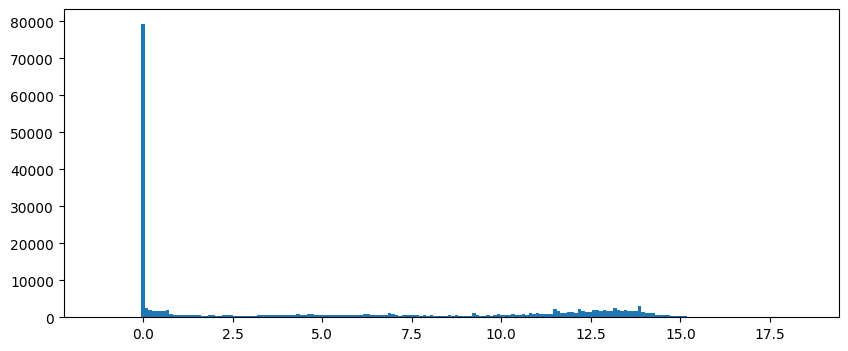

In [96]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(y_train_df['target']), bins = 200);

В распределении очень много нулей, так что стоит смотреть чуть уже:

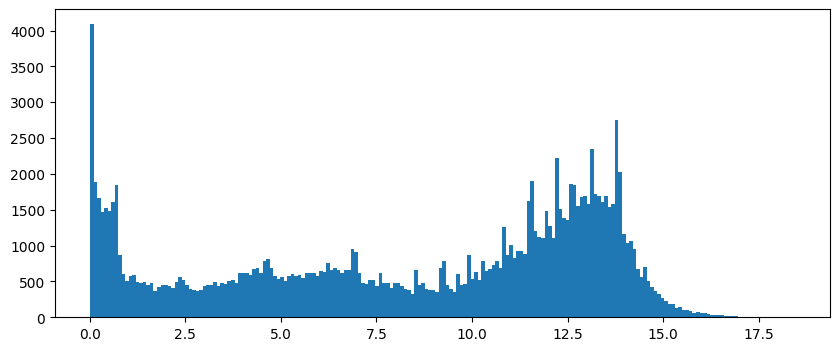

In [97]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(y_train_df.loc[y_train_df['target'] > 0, 'target']), bins = 200);

Распределение выглядит очень похожим на смесь:
- Есть клиенты с значениями около нуля
- Есть компонента смеси с центром в районе 6, то есть ~400 (np.exp(6) - 1)
- Есть компонента справа, с центров в районе 13, то есть ~440,000
- И есть еще клиенты с ровно 0, которых мы убрали с графика

In [98]:
# обозначим номера столбцов у categorical_features_full


train_card_spending[categorical_features_full] = train_card_spending[categorical_features_full].astype(str)
categorical_features_indices = [train_card_spending.columns.get_loc(col) for col in categorical_features_full]
categorical_features_indices

[4, 8, 2, 6, 3, 7, 5, 1]

In [99]:
# Обучим catboost и уберем признаки с нулевой важностью

def is_important_features(df, y_train_df, categorical_features_full, learning_rate=0.05, iterations=100):
    #df[categorical_features_full] = df[categorical_features_full].astype(str)
    df = df.drop(columns = 'user_id')
    # Создаем Pool для CatBoost
    train_pool = Pool(df, label= np.log1p(y_train_df['target']), cat_features = categorical_features_full )

    # Инициализируем и обучаем модель
    model = CatBoostRegressor(
        iterations = iterations,
        learning_rate = learning_rate,
        depth=6,
        loss_function='RMSE',
        random_seed=42,
        nan_mode='Min',
        verbose = 20,
        task_type = 'GPU',
        devices = 'all',
        bootstrap_type = 'Poisson',
        max_ctr_complexity =  4
        
        )
    model.fit(train_pool)

    # Получаем важность признаков
    feature_importance = model.get_feature_importance()
    feature_names = df.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df
    
importance_df = is_important_features(train_card_spending, y_train_df, categorical_features_full, learning_rate = 0.1, iterations=100)

print("Ранжирование признаков по важности:")
print(importance_df.to_string(index=False))


0:	learn: 5.5463937	total: 726ms	remaining: 1m 11s
20:	learn: 5.4174088	total: 5.56s	remaining: 20.9s
40:	learn: 5.4013990	total: 10.4s	remaining: 15s
60:	learn: 5.3971840	total: 15s	remaining: 9.59s
80:	learn: 5.3876122	total: 19.8s	remaining: 4.64s
99:	learn: 5.3827998	total: 23.2s	remaining: 0us
Ранжирование признаков по важности:
                            Feature  Importance
                   sum_tr_cash_in_1    6.071254
sum_tr_music_digital_video_store_12    4.756316
                    cnt_tr_top_up_6    3.565392
                sum_tr_publ_util_6m    3.480460
                      sum_tr_all_7d    3.360796
           sum_tr_fashion_retail_12    3.301746
  sum_tr_medical_health_services_12    3.147906
   sum_tr_medical_health_services_3    2.820296
               sum_tr_books_store_6    2.463448
                   cnt_tr_unknown_3    2.146145
                sum_tr_alkochol_12m    2.114288
      cnt_tr_spa_beauty_services_12    1.935736
                   cnt_tr_top_up_12    1

In [100]:
#ненулевая важность
mask = importance_df['Importance'] > 0 
selected_features = importance_df[mask]
print("\nОтобранные признаки (ненулевая важность):", selected_features['Feature'].tolist())


Отобранные признаки (ненулевая важность): ['sum_tr_cash_in_1', 'sum_tr_music_digital_video_store_12', 'cnt_tr_top_up_6', 'sum_tr_publ_util_6m', 'sum_tr_all_7d', 'sum_tr_fashion_retail_12', 'sum_tr_medical_health_services_12', 'sum_tr_medical_health_services_3', 'sum_tr_books_store_6', 'cnt_tr_unknown_3', 'sum_tr_alkochol_12m', 'cnt_tr_spa_beauty_services_12', 'cnt_tr_top_up_12', 'sum_tr_buy_1m', 'cnt_tr_restaurant_1m', 'cnt_tr_computer_program_retail_3', 'sum_tr_cash_services_3', 'sum_tr_publ_util_1m', 'sum_tr_medical_health_services_1', 'sum_tr_food_retail_3', 'sum_tr_supermarkets_3', 'sum_tr_florist_6', 'sum_tr_business_services_6', 'cnt_tr_cash_in_6', 'cnt_tr_restaurants_3', 'sum_tr_restaurant_12m', 'sum_tr_fashion_retail_1', 'sum_tr_transportation_other_12', 'sum_tr_mobile_12m', 'sum_tr_lodging_12', 'cnt_tr_computer_program_retail_12', 'sum_tr_construction_services_6', 'sum_tr_appliance_retail_12', 'sum_tr_auto_services_12', 'sum_tr_music_digital_video_store_6', 'cnt_tr_spa_beauty

In [101]:
len(selected_features)

240

In [102]:
selected_features

,Feature,Importance
306,sum_tr_cash_in_1,6.071254
377,sum_tr_music_digital_video_store_12,4.756316
236,cnt_tr_top_up_6,3.565392
395,sum_tr_publ_util_6m,3.480460
273,sum_tr_all_7d,3.360796
...,...,...
24,cnt_tr_alkochol_12m,0.000029
118,cnt_tr_games_store_12,0.000027
152,cnt_tr_membership_clubs_12,0.000021
21,cnt_tr_airlines_12,0.000007


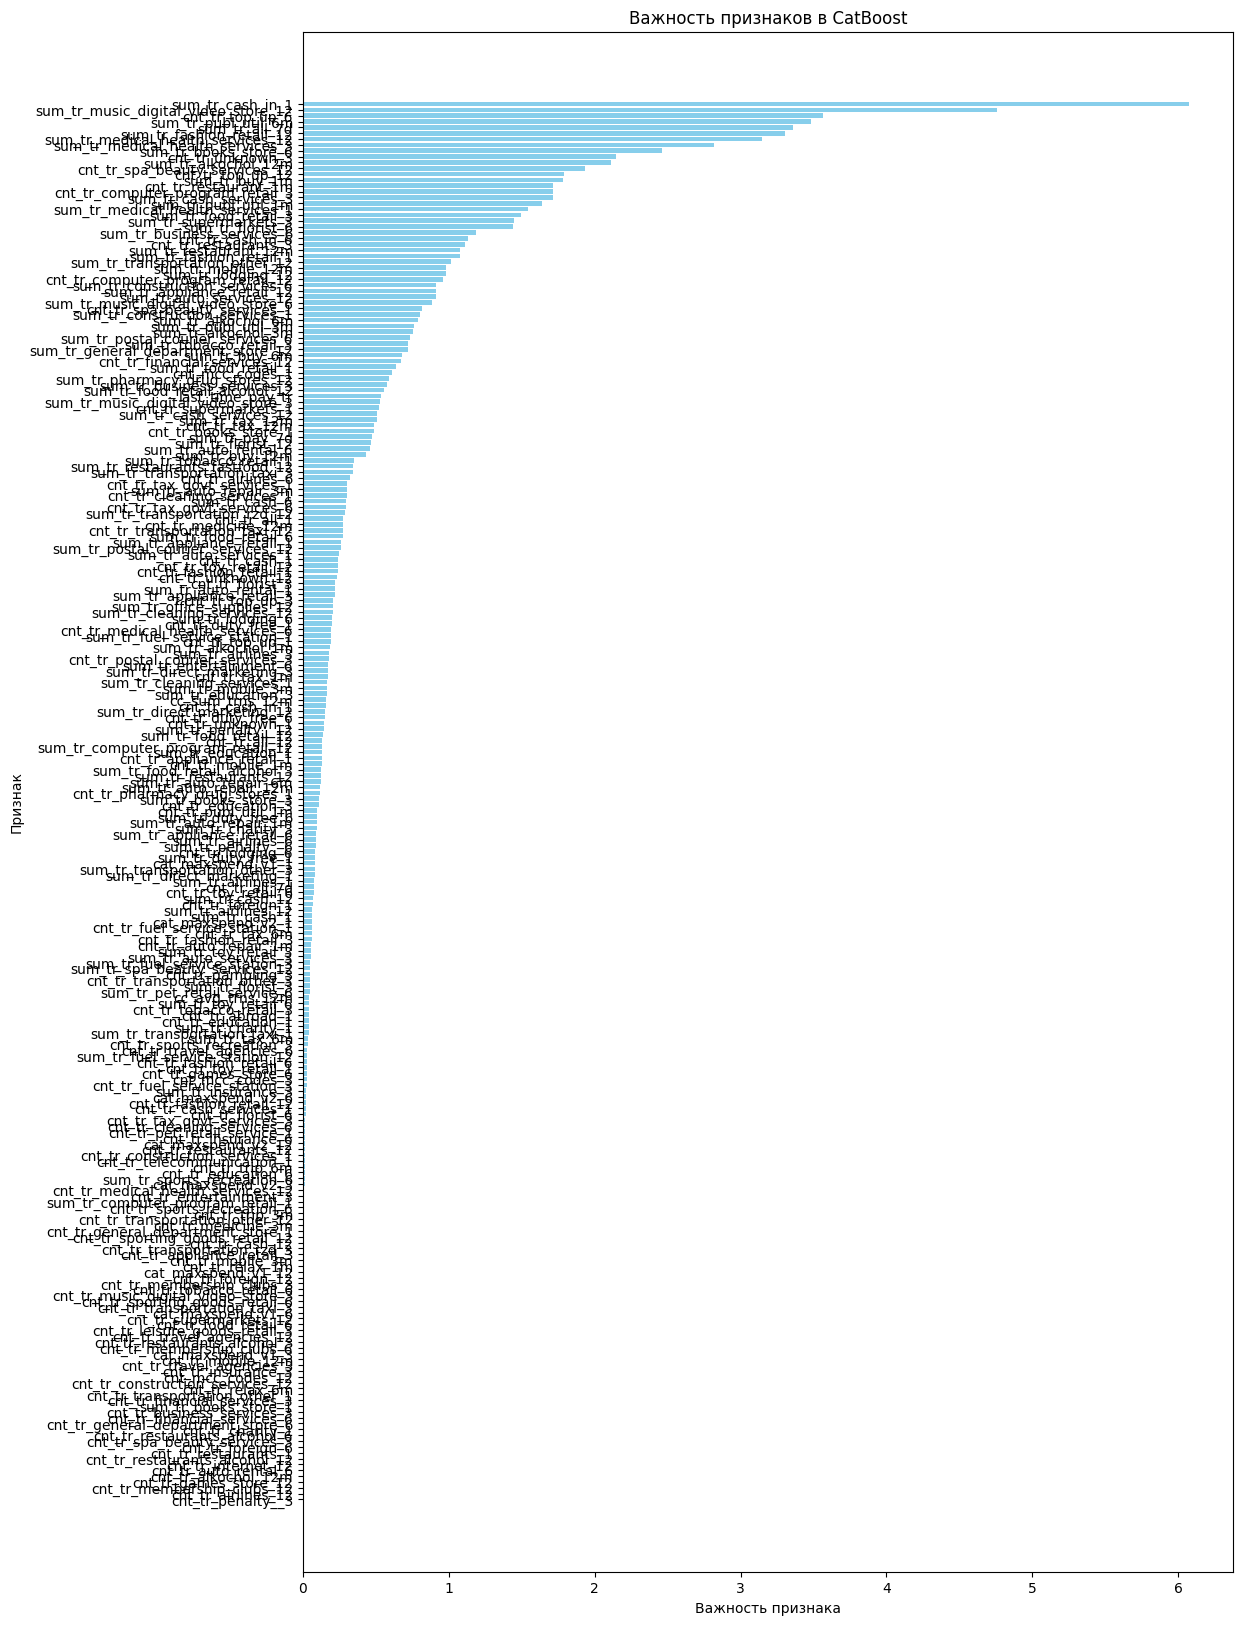

In [103]:
# Визуализация ненулевых по важности 

plt.figure(figsize=(12, 20))
plt.barh(selected_features['Feature'], selected_features['Importance'], color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в CatBoost')
plt.gca().invert_yaxis()  # Самые важные признаки сверху
plt.show()

In [104]:
# оставим только список из selected_features
selected_features_list = selected_features['Feature'].tolist()

In [105]:
display(len(categorical_features_full))
categorical_features_full = [feature for feature in categorical_features_full if feature in selected_features_list]
display(len(categorical_features_full))

8

8

#### **4. Разделение данных и балансировка**  
- **Train/Test Split**:  
  ```python
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  ``` 

In [106]:
# Финальная проверка всех категориальных признаков
for col in categorical_features_full:
    print(f"\nПроверка колонки {col}:")
    print("Тип данных:", train[col].dtype)
    print("Уникальные значения:", train[col].unique()[:5])
    print("Количество пропусков:", train[col].isna().sum())


Проверка колонки cat_maxspend_v1_6:
Тип данных: object
Уникальные значения: ['None' 'LEISURE GOODS RETAIL' 'TRANSPORTATION_OTHER' 'APPLIANCE RETAIL'
 'TELECOMMUNICATION']
Количество пропусков: 0

Проверка колонки cat_maxspend_v2_6:
Тип данных: object
Уникальные значения: ['None' 'LEISURE GOODS RETAIL' 'TRANSPORTATION_OTHER' 'APPLIANCE RETAIL'
 'TELECOMMUNICATION']
Количество пропусков: 0

Проверка колонки cat_maxspend_v1_12:
Тип данных: object
Уникальные значения: ['None' 'MEDICAL/HEALTH SERVICES' 'RESTAURANTS_FASTFOOD'
 'TRANSPORTATION_OTHER' 'APPLIANCE RETAIL']
Количество пропусков: 0

Проверка колонки cat_maxspend_v2_12:
Тип данных: object
Уникальные значения: ['None' 'MEDICAL/HEALTH SERVICES' 'RESTAURANTS_FASTFOOD'
 'TRANSPORTATION_OTHER' 'APPLIANCE RETAIL']
Количество пропусков: 0

Проверка колонки cat_maxspend_v1_3:
Тип данных: object
Уникальные значения: ['None' 'LEISURE GOODS RETAIL' 'TRANSPORTATION_OTHER' 'APPLIANCE RETAIL'
 'MEDICAL/HEALTH SERVICES']
Количество пропусков: 0


In [107]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(train_card_spending[selected_features_list], np.log1p(y_train_df['target']), test_size=0.2, random_state=42)


In [108]:
#from catboost.utils import get_gpu_device_count

#gpu_count = get_gpu_device_count()
#print(f"Доступно GPU: {gpu_count}")

#### **5. Оптимизация гиперпараметров (Optuna)**  

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna

# Функция для оптимизации (минимизация RMSE)
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 5, log=True),
        'border_count': trial.suggest_categorical('border_count', [64, 128, 254]),
        'random_strength': trial.suggest_float('random_strength', 0.5, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 2.0),
        'grow_policy': 'Depthwise',
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'loss_function': 'RMSE',
        'verbose': False,
        'random_seed': 42,
        'nan_mode': 'Min',
        'task_type': 'GPU',
        'devices': 'all',
        #'bootstrap_type': 'Poisson',
        'max_ctr_complexity': 4
    }
    
    # Инициализация кросс-валидации
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        # Разделение данных на train/val для текущего фолда
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Создание Pool для текущего фолда
        train_pool = Pool(
            data=X_tr,
            label=y_tr,
            cat_features=categorical_features_full,
            feature_names=list(X_train.columns))
        
        val_pool = Pool(
            data=X_val,
            label=y_val,
            cat_features=categorical_features_full,
            feature_names=list(X_train.columns))
        
        # Обучение модели
        model = CatBoostRegressor(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=50,
            verbose=0
        )
        
        # Предсказание и расчет RMSE для фолда
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)
    
    # Возвращаем средний RMSE по всем фолдам
    return np.mean(rmse_scores)

# Запуск Optuna (direction='minimize' для RMSE)
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=20),
    pruner=optuna.pruners.HyperbandPruner()
)

# Запуск оптимизации (30 trials)
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Лучшие параметры
print("Best trial:")
trial = study.best_trial
print(f"  Mean CV RMSE: {trial.value:.4f}")
print("  Best params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Финальное обучение на всех данных с лучшими параметрами
best_model = CatBoostRegressor(**trial.params, task_type = 'GPU', devices = 'all')
best_model.fit(
    Pool(X_train, y_train, cat_features=categorical_features_full),
    verbose=False
)

# Оценка на тестовом наборе
test_preds = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"\nFinal Test RMSE: {final_rmse:.4f}")

[I 2025-04-01 15:40:33,415] A new study created in memory with name: no-name-6122ab1e-3ae1-4ed2-b0e6-6940f8dc50fb


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-04-01 15:40:48,416] Trial 0 finished with value: 5.569454784463711 and parameters: {'iterations': 1062, 'learning_rate': 0.19038928974993366, 'depth': 9, 'l2_leaf_reg': 0.4128205343826223, 'border_count': 64, 'random_strength': 4.3977926559872085, 'bagging_temperature': 1.4016725176148133, 'min_data_in_leaf': 36}. Best is trial 0 with value: 5.569454784463711.
[I 2025-04-01 15:41:07,288] Trial 1 finished with value: 5.569454784463732 and parameters: {'iterations': 530, 'learning_rate': 0.1941324211715889, 'depth': 10, 'l2_leaf_reg': 0.037419406111184966, 'border_count': 254, 'random_strength': 2.86140394234507, 'bagging_temperature': 1.1479175279631737, 'min_data_in_leaf': 15}. Best is trial 0 with value: 5.569454784463711.
[I 2025-04-01 15:41:21,076] Trial 2 finished with value: 5.569454784462878 and parameters: {'iterations': 1418, 'learning_rate': 0.03220130282714816, 'depth': 7, 'l2_leaf_reg': 0.09745399020374085, 'border_count': 128, 'random_strength': 2.814054972861252, '

Best params:

Best trial:

  Mean CV RMSE: 5.5695

  Best params:

    iterations: 1440

    learning_rate: 0.005562454940567271

    depth: 8

    l2_leaf_reg: 0.01051897793471837

    border_count: 254

    random_strength: 2.106677724935756

    bagging_temperature: 1.977147577987

    min_data_in_leaf: 20
    

Final Test RMSE: 5.2728


### Предобработка test_data

In [144]:
test = pd.read_parquet('data/test_card_spending.parquet')

In [145]:
# зпускаем наши функцию просмотра инфы об датасете

display_main_info(test, card_spending_dict)

,user_id,cat_maxspend_v1_1,cat_maxspend_v1_12,cat_maxspend_v1_3,cat_maxspend_v1_6,cat_maxspend_v2_1,cat_maxspend_v2_12,cat_maxspend_v2_3,cat_maxspend_v2_6,cc_avg_trns_12m,...,sum_tr_travel_agencies_3,sum_tr_travel_agencies_6,sum_tr_trip_12m,sum_tr_trip_1m,sum_tr_trip_3m,sum_tr_trip_6m,sum_tr_unknown_1,sum_tr_unknown_12,sum_tr_unknown_3,sum_tr_unknown_6
0,1000008,None,TAX/GOVT SERVICES,TAX/GOVT SERVICES,TAX/GOVT SERVICES,None,TAX/GOVT SERVICES,TAX/GOVT SERVICES,TAX/GOVT SERVICES,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000009,None,None,None,None,None,None,None,None,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000013,None,TELECOMMUNICATION,PET_RETAIL/SERVICE,TELECOMMUNICATION,None,TELECOMMUNICATION,PET_RETAIL/SERVICE,TELECOMMUNICATION,840.871704,...,NaN,750.812805,11460.886719,NaN,NaN,805.740906,NaN,20282.757812,NaN,NaN
3,1000016,None,RESTAURANTS_FASTFOOD,RESTAURANTS_FASTFOOD,RESTAURANTS_FASTFOOD,None,RESTAURANTS_FASTFOOD,RESTAURANTS_FASTFOOD,RESTAURANTS_FASTFOOD,5.571924,...,NaN,NaN,15976.687500,NaN,NaN,NaN,NaN,465.916595,NaN,NaN
4,1000017,None,TRANSPORTATION_OTHER,None,None,None,TRANSPORTATION_OTHER,None,None,4.737999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,user_id,cat_maxspend_v1_1,cat_maxspend_v1_12,cat_maxspend_v1_3,cat_maxspend_v1_6,cat_maxspend_v2_1,cat_maxspend_v2_12,cat_maxspend_v2_3,cat_maxspend_v2_6,cc_avg_trns_12m,...,sum_tr_travel_agencies_3,sum_tr_travel_agencies_6,sum_tr_trip_12m,sum_tr_trip_1m,sum_tr_trip_3m,sum_tr_trip_6m,sum_tr_unknown_1,sum_tr_unknown_12,sum_tr_unknown_3,sum_tr_unknown_6
318446,2499983,RESTAURANTS,FASHION RETAIL,FUEL/SERVICE STATION,FASHION RETAIL,RESTAURANTS,FASHION RETAIL,FUEL/SERVICE STATION,FASHION RETAIL,4146.046387,...,NaN,86199.515625,348713.90625,3035.856689,5621.630371,243210.53125,NaN,31198.937500,12664.09668,16319.516602
318447,2499984,None,None,None,None,None,None,None,None,6.870225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318448,2499989,None,None,None,None,None,None,None,None,-0.885338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318449,2499991,None,RESTAURANTS_FASTFOOD,None,None,None,RESTAURANTS_FASTFOOD,None,None,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318450,2499992,GENERAL DEPARTMENT STORE,AUTO SERVICES,GENERAL DEPARTMENT STORE,AUTO SERVICES,GENERAL DEPARTMENT STORE,AUTO SERVICES,GENERAL DEPARTMENT STORE,AUTO SERVICES,1604.343750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17888.574219,NaN,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318451 entries, 0 to 318450
Columns: 631 entries, user_id to sum_tr_unknown_6
dtypes: float64(622), int32(1), object(8)
memory usage: 1.5+ GB


None

float64    622
object       8
int32        1
Name: count, dtype: int64

Index(['cat_maxspend_v1_1', 'cat_maxspend_v1_12', 'cat_maxspend_v1_3',
       'cat_maxspend_v1_6', 'cat_maxspend_v2_1', 'cat_maxspend_v2_12',
       'cat_maxspend_v2_3', 'cat_maxspend_v2_6'],
      dtype='object')

,feature,modeling_type,description,category,feature_group
1,cat_maxspend_v1_1,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 1 мес,MCC категория (максимальные траты),Карты/Категории трат
2,cat_maxspend_v1_12,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 12 мес,MCC категория (максимальные траты),Карты/Категории трат
3,cat_maxspend_v1_3,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 3 мес,MCC категория (максимальные траты),Карты/Категории трат
4,cat_maxspend_v1_6,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах) за последние 6 мес,MCC категория (максимальные траты),Карты/Категории трат
5,cat_maxspend_v2_1,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail) за последние 1 мес,MCC категория (максимальные траты),Карты/Категории трат
6,cat_maxspend_v2_12,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail) за последние 12 мес,MCC категория (максимальные траты),Карты/Категории трат
7,cat_maxspend_v2_3,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail)за последние 3 мес,MCC категория (максимальные траты),Карты/Категории трат
8,cat_maxspend_v2_6,categorical,Mcc-категория с максимальными тратами (за исключнием операций с наличными и трат в супермаркетах + food retail)за последние 6 мес,MCC категория (максимальные траты),Карты/Категории трат


category
Транзакции                                178
Категория MCC insurance                     8
Категория MCC restaurants_delivery          8
Категория MCC leisuregoods retail           8
Категория MCC lodging                       8
Категория MCC medical/health services       8
Категория MCC membership clubs              8
Категория MCC music/digital/videostore      8
Категория MCC office_supplies               8
Категория MCC penalty                       8
Категория MCC pet_ retail/service           8
Категория MCC pharmacy/drugstores           8
Категория MCC postal/courier services       8
Категория MCC restaurants                   8
Категория MCC restaurants_alcohol           8
Категория MCC restaurants_fastfood          8
Категория MCC pos                           8
Категория MCC spa/beauty services           8
Категория MCC sporting goods retail         8
Категория MCC sports&recreation             8
Категория MCC supermarkets                  8
Категория MCC tax/govt se

feature_group
Карты/Категории трат    630
Name: count, dtype: int64

modeling_type
numerical      622
categorical      8
ключ             1
Name: count, dtype: int64

In [ ]:

#categorical_features_full = full_catlist(test, card_spending_dict)


In [147]:
test = fill_cat_nan(test, categorical_features_full)

In [152]:
test[selected_features_list]

,sum_tr_cash_in_1,sum_tr_music_digital_video_store_12,cnt_tr_top_up_6,sum_tr_publ_util_6m,sum_tr_all_7d,sum_tr_fashion_retail_12,sum_tr_medical_health_services_12,sum_tr_medical_health_services_3,sum_tr_books_store_6,cnt_tr_unknown_3,...,cnt_tr_foreign_6,cnt_tr_restaurants_1,cnt_tr_restaurants_alcohol_12,cnt_tr_internet_12,cnt_tr_auto_rental_6,cnt_tr_alkochol_12m,cnt_tr_games_store_12,cnt_tr_membership_clubs_12,cnt_tr_airlines_12,cnt_tr_penalty__3
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3290.788574,43.0,NaN,NaN,3156.652832,NaN,NaN,NaN,0.0,...,0.0,0.0,2.0,233.0,0.0,7.0,0.0,0.0,2.0,0.0
3,143156.187500,NaN,6.0,881.989319,NaN,2606.362549,NaN,NaN,NaN,0.0,...,0.0,0.0,2.0,38.0,0.0,19.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318446,29977.529297,305.709930,12.0,8040.157715,75955.867188,442707.718750,218940.59375,4764.001465,161.357635,5.0,...,0.0,6.0,0.0,65.0,0.0,7.0,0.0,3.0,2.0,0.0
318447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [153]:
for col in categorical_features_full:
    test[col] = test[col].astype(str)

In [154]:
# Финальная проверка всех категориальных признаков
for col in categorical_features_full:
    print(f"\nПроверка колонки {col}:")
    print("Тип данных:", test[col].dtype)
    print("Уникальные значения:", test[col].unique()[:5])
    print("Количество пропусков:", test[col].isna().sum())


Проверка колонки cat_maxspend_v1_6:
Тип данных: object
Уникальные значения: ['TAX/GOVT SERVICES' 'None' 'TELECOMMUNICATION' 'RESTAURANTS_FASTFOOD'
 'PHARMACY/DRUG STORES']
Количество пропусков: 0

Проверка колонки cat_maxspend_v2_6:
Тип данных: object
Уникальные значения: ['TAX/GOVT SERVICES' 'None' 'TELECOMMUNICATION' 'RESTAURANTS_FASTFOOD'
 'PHARMACY/DRUG STORES']
Количество пропусков: 0

Проверка колонки cat_maxspend_v1_12:
Тип данных: object
Уникальные значения: ['TAX/GOVT SERVICES' 'None' 'TELECOMMUNICATION' 'RESTAURANTS_FASTFOOD'
 'TRANSPORTATION_OTHER']
Количество пропусков: 0

Проверка колонки cat_maxspend_v2_12:
Тип данных: object
Уникальные значения: ['TAX/GOVT SERVICES' 'None' 'TELECOMMUNICATION' 'RESTAURANTS_FASTFOOD'
 'TRANSPORTATION_OTHER']
Количество пропусков: 0

Проверка колонки cat_maxspend_v1_3:
Тип данных: object
Уникальные значения: ['TAX/GOVT SERVICES' 'None' 'PET_RETAIL/SERVICE' 'RESTAURANTS_FASTFOOD'
 'PHARMACY/DRUG STORES']
Количество пропусков: 0

Проверка ко

In [155]:
X_test = test[selected_features_list]

In [156]:
# Предсказания на тесте
test_preds = best_model.predict(X_test)

In [ ]:
sample = pd.read_csv('data/sample_submit_naive.csv')
sample

,user_id,predict
0,1000008,1.004656e+06
1,1000009,0.000000e+00
2,1000013,5.047758e+02
3,1000016,1.680799e+05
4,1000017,2.222542e+02
...,...,...
318446,2499983,1.093786e+06
318447,2499984,0.000000e+00
318448,2499989,1.080357e+04
318449,2499991,0.000000e+00


In [ ]:
# Проверка построчного совпадения (если индексы одинаковы)
if (sample['user_id'] == test['user_id']).all():
    print("Все строки в user_id совпадают")
else:
    print("Есть различия в строках")
    
    # Поиск строк с различиями
    diff_mask = sample['user_id'] != test['user_id']
    differences = pd.DataFrame({
        'sample': sample.loc[diff_mask, 'user_id'],
        'X_test': test.loc[diff_mask, 'user_id']
    })
    print("Различающиеся строки:")
    print(differences)

Все строки в user_id совпадают


In [ ]:
test_full_predict = np.exp(test_preds) - 1

In [ ]:
sample['predict'] = test_full_predict

In [ ]:
sample

,user_id,predict
0,1000008,472231.948054
1,1000009,-0.109762
2,1000013,2.758265
3,1000016,543.935088
4,1000017,1.746508
...,...,...
318446,2499983,134474.840525
318447,2499984,1.122392
318448,2499989,7338.015694
318449,2499991,0.708257


In [ ]:
sample.to_csv('shved_submit_1.csv', index=False)